# Bike sharing demand forecast (on daily data)

Predict bike sharing demand as a function of seasonal and weather conditions.

Data origin:
- original full dataset (by hour, not used here): https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- simplified dataset (by day, with some simple scaling): https://www.hds.utc.fr/~tdenoeux/dokuwiki/en/aec
    - description: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/exam_2019_ace_.pdf
    - data: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/bike_sharing_day.csv.zip
    
Note that even if we are estimating a time serie, we are not using here a recurrent neural network as we assume the temporal dependence to be negligible (i.e. Y_t = f(X_t) alone).

In [1]:
using Pkg
function addIfNeeded(pkgs...)
    isinstalled(pkg::String) = any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
    [Pkg.add(pkg) for pkg in pkgs  if !isinstalled(pkg)]
end

addIfNeeded("DataFrames","CSV","StatsPlots","Distributions")

using LinearAlgebra, Random, DataFrames, CSV, StatsPlots, BetaML.Trees
import Distributions: Uniform

import Random:seed!
seed!(123)

┌ Info: Precompiling BetaML [024491cd-cc6b-443e-8034-08ea7eb7db2b]
└ @ Base loading.jl:1278


MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

In [2]:
# Data loading and cleaning..
baseDir = "assets/bikeSharingDemandForecast/"
data = CSV.File(joinpath(baseDir,"bike_sharing_day.csv"),delim=',') |> DataFrame
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,instant,366.0,1,366.0,731,,,Int64
2,dteday,,2011-01-01,,2012-12-31,731,,Date
3,season,2.49658,1,3.0,4,,,Int64
4,yr,0.500684,0,1.0,1,,,Int64
5,mnth,6.51984,1,7.0,12,,,Int64
6,holiday,0.0287278,0,0.0,1,,,Int64
7,weekday,2.99726,0,3.0,6,,,Int64
8,workingday,0.683995,0,1.0,1,,,Int64
9,weathersit,1.39535,1,1.0,3,,,Int64


In [3]:
x    = hcat(data[:,[:instant,:season,:yr,:mnth,:holiday,:weekday,:workingday,:weathersit,:temp,:atemp,:hum,:windspeed]])
y    = data[:,16] 

# Split the data in training/testing sets
ntrain    = Int64(round(size(x,1)*0.75))
nval      = Int64(round(size(x,1)*0.125))
ntest     = size(x,1) - (ntrain+nval)
xtrain    = x[1:ntrain,:]
ytrain    = y[1:ntrain]
xval      = x[(ntrain+1):(ntrain+nval),:]
yval      = y[(ntrain+1):(ntrain+nval)]
xtest     = x[ntrain+nval+1:end,:]
ytest     = y[ntrain+nval+1:end]

92-element Array{Int64,1}:
 6778
 4639
 7572
 7328
 8156
 7965
 3510
 5478
 6392
 7691
 7570
 7282
 7109
    ⋮
 4128
 3623
 1749
 1787
  920
 1013
  441
 2114
 3095
 1341
 1796
 2729

## Decision Trees

In [4]:
function findBestDepth(xtrain,ytrain,xval,yval,atteptedDepths)
    bestDepth = 1
    bestMre   = +Inf
    for ad in atteptedDepths
        myTree = buildTree(xtrain,ytrain, maxDepth=ad)
        ŷval   = Trees.predict(myTree, xval)
        mreVal = meanRelError(ŷval,yval)
        println("$ad : $mreVal")
        if mreVal < bestMre
            bestDepth = ad
            bestMre   = mreVal
        end
    end
    return (bestDepth, bestMre)
end

findBestDepth (generic function with 1 method)

In [5]:
bestDepth, bestMre = findBestDepth(xtrain,ytrain,xval,yval,1:20)

1 : 0.4127457010251527
2 : 0.27957279496923804
3 : 0.13440709867155343
4 : 0.11543645357414807
5 : 0.09823897896834381
6 : 0.11695408601762691
7 : 0.12455338425579428
8 : 0.12243694244101945
9 : 0.13086074249979696
10 : 0.11951022928177926
11 : 0.1382265316799392
12 : 0.13448560341131688
13 : 0.12432901697046307
14 : 0.13283779694928782
15 : 0.13616679801429252
16 : 0.1371506555310978
17 : 0.1299416584885876
18 : 0.13255170283975787
19 : 0.13302407473783337
20 : 0.13077140421334132


(5, 0.09823897896834381)

In [6]:
myTree = buildTree(xtrain,ytrain, maxDepth=bestDepth)

BetaML.Trees.DecisionNode(BetaML.Trees.Question(9, 0.433913), BetaML.Trees.DecisionNode(BetaML.Trees.Question(1, 433), BetaML.Trees.DecisionNode(BetaML.Trees.Question(11, 0.774583), BetaML.Trees.DecisionNode(BetaML.Trees.Question(12, 0.192783), BetaML.Trees.Leaf([3372, 4996, 2843, 4359, 4972], 4108.4, 5), BetaML.Trees.Leaf([4378, 5892, 6093, 6230, 6871, 6169, 5115, 5260, 5099], 5678.555555555556, 5), 4), BetaML.Trees.DecisionNode(BetaML.Trees.Question(1, 496), BetaML.Trees.Leaf([6572, 7030, 7429, 6118, 7424, 7384, 7639, 8294, 7129, 6073  …  5823, 7458, 6891, 6779, 7442, 7335, 6879, 5463, 5687, 5531], 6850.893617021276, 5), BetaML.Trees.Leaf([5382, 5298, 5847, 6312, 6192, 7836, 6153, 8362, 5558, 5698  …  6304, 5572, 5740, 6421, 6296, 6883, 6359, 6273, 5728, 4717], 6208.4390243902435, 5), 4), 3), BetaML.Trees.DecisionNode(BetaML.Trees.Question(8, 3), BetaML.Trees.DecisionNode(BetaML.Trees.Question(6, 3), BetaML.Trees.Leaf([1996, 1842, 2416, 2424, 1817], 2099.0, 5), BetaML.Trees.Leaf([271

In [7]:
ŷtrain = Trees.predict(myTree, xtrain)
ŷval   = Trees.predict(myTree, xval)
ŷtest  = Trees.predict(myTree, xtest)


92-element Array{Float64,1}:
 6850.893617021276
 5678.555555555556
 5678.555555555556
 6850.893617021276
 6850.893617021276
 6850.893617021276
 5225.7692307692305
 5225.7692307692305
 6850.893617021276
 6850.893617021276
 6850.893617021276
 6850.893617021276
 5225.7692307692305
    ⋮
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 2120.5
 5225.7692307692305
 2120.5
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305

In [8]:
mreTrain = meanRelError(ŷtrain,ytrain)

0.18366509363381545

In [9]:
mreVal = meanRelError(ŷval,yval)

0.09823897896834381

In [10]:
mreTest  = meanRelError(ŷtest,ytest)

2.421448822196853

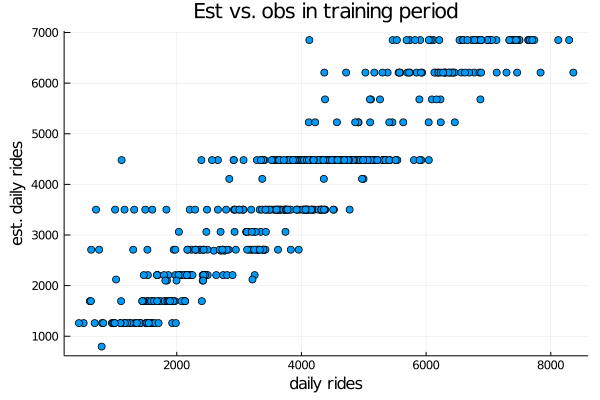

In [11]:
scatter(ytrain,ŷtrain,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period")

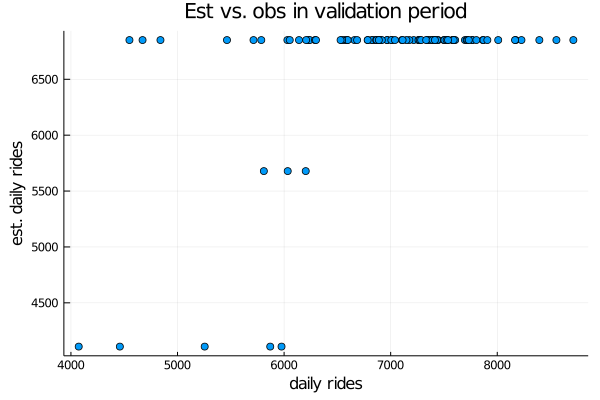

In [12]:
scatter(yval,ŷval,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period")

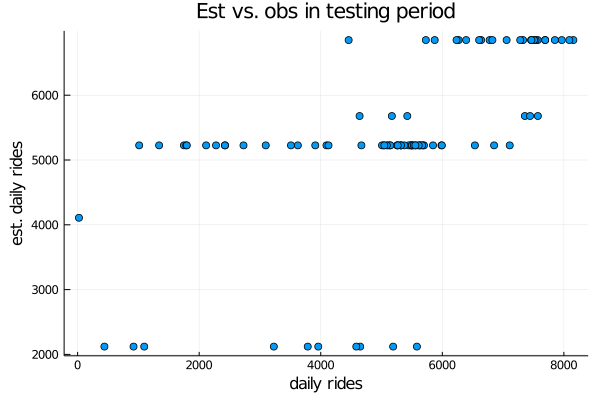

In [13]:
scatter(ytest,ŷtest,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period")

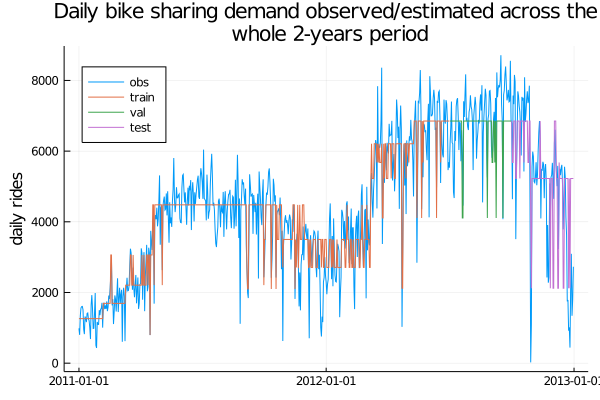

In [14]:
# Full period plot (2 years)
ŷtrainfull = vcat(ŷtrain,fill(missing,nval+ntest))
ŷvalfull = vcat(fill(missing,ntrain), ŷval, fill(missing,ntest))
ŷtestfull = vcat(fill(missing,ntrain+nval), ŷtest)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfull ŷvalfull ŷtestfull], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period")

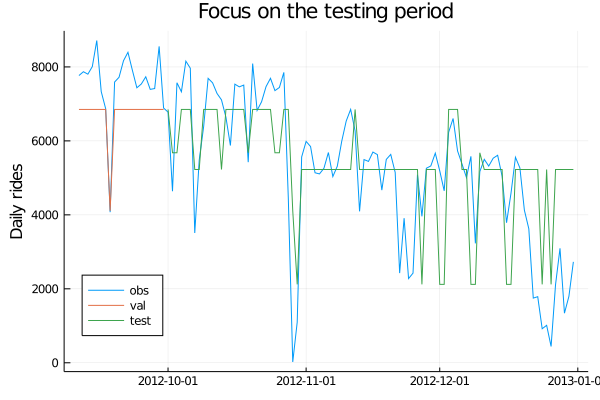

In [15]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfull[stc:endc] ŷtestfull[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period")

## Random forest

In [16]:
function findBestDepth(xtrain,ytrain,xval,yval,atteptedDepths)
    bestDepth = 1
    bestMre   = +Inf
    for ad in atteptedDepths
        myForest = buildForest(xtrain,ytrain, 20, maxDepth=ad)[1]
        ŷval   = Trees.predict(myForest, xval)
        mreVal = meanRelError(ŷval,yval)
        println("$ad : $mreVal")
        if mreVal < bestMre
            bestDepth = ad
            bestMre   = mreVal
        end
    end
    return (bestDepth, bestMre)
end

findBestDepth (generic function with 1 method)

In [17]:
bestDepth, bestMre = findBestDepth(xtrain,ytrain,xval,yval,1:30)

1 : 0.409671150151936
2 : 0.26363194804703105
3 : 0.20487558477752493
4 : 0.1463119585237976
5 : 0.1512854938390643
6 : 0.12227102576979904
7 : 0.15853951663739552
8 : 0.1236301410049137
9 : 0.13496161473007692
10 : 0.16525691328144707
11 : 0.13024742646600962
12 : 0.13190528693135842
13 : 0.15437141883272135
14 : 0.12287203416606036
15 : 0.11424549219007923
16 : 0.12709443951902447
17 : 0.15975394381570954
18 : 0.1276605501705967
19 : 0.14008056314220316
20 : 0.10385687435726153
21 : 0.10882384157493537
22 : 0.13090104293631177
23 : 0.143057495773688
24 : 0.19332811109685144
25 : 0.14158150003532366
26 : 0.16337055916852036
27 : 0.1277880550439723
28 : 0.16930236930248513
29 : 0.11796614931544538
30 : 0.13133340979292094


(20, 0.10385687435726153)

In [18]:
myForest,notUsedData = buildForest(xtrain,ytrain, 30, maxDepth=bestDepth)

(Union{BetaML.Trees.DecisionNode, BetaML.Trees.Leaf}[BetaML.Trees.DecisionNode(BetaML.Trees.Question(1, 432), BetaML.Trees.DecisionNode(BetaML.Trees.Question(4, 5), BetaML.Trees.DecisionNode(BetaML.Trees.Question(11, 0.60125), BetaML.Trees.DecisionNode(BetaML.Trees.Question(12, 0.233204), BetaML.Trees.DecisionNode(BetaML.Trees.Question(9, 0.598333), BetaML.Trees.DecisionNode(BetaML.Trees.Question(12, 0.237563), BetaML.Trees.Leaf([4127, 4127], 4127.0, 7), BetaML.Trees.Leaf([4359], 4359.0, 7), 6), BetaML.Trees.Leaf([5728, 5728], 5728.0, 6), 5), BetaML.Trees.DecisionNode(BetaML.Trees.Question(8, 2), BetaML.Trees.DecisionNode(BetaML.Trees.Question(6, 4), BetaML.Trees.DecisionNode(BetaML.Trees.Question(9, 0.621667), BetaML.Trees.Leaf([6883, 6883, 6883], 6883.0, 8), BetaML.Trees.Leaf([6421], 6421.0, 8), 7), BetaML.Trees.DecisionNode(BetaML.Trees.Question(11, 0.744167), BetaML.Trees.DecisionNode(BetaML.Trees.Question(1, 508), BetaML.Trees.DecisionNode(BetaML.Trees.Question(6, 2), BetaML.Trees

In [19]:
treesWeights = computeTreesWeights(myForest,notUsedData,xtrain,ytrain,β=50)

30-element Array{Any,1}:
 5.2258984391332276e-5
 1.5425935793731478e-5
 4.34112212840372e-6
 1.6604605926393582e-5
 3.2059440200204394e-6
 4.2333392044660254e-5
 1.1334879802355762e-5
 1.7465082971175716e-5
 2.789942197434189e-5
 1.712933371046973e-6
 1.4691819710745177e-5
 6.902464353347016e-5
 9.220106296803778e-7
 ⋮
 1.9576630335848056e-5
 3.863458628424559e-6
 6.72472383502272e-5
 1.851833761208482e-5
 2.1313327760928137e-5
 9.308022974060791e-6
 1.8619978768450598e-6
 1.9807352447798966e-6
 4.597449087345406e-5
 8.166800715312627e-6
 1.7910554290250367e-6
 1.5035919150996065e-6

In [20]:
ŷtrain = Trees.predict(myForest, xtrain)
ŷval   = Trees.predict(myForest, xval)
ŷtest  = Trees.predict(myForest, xtest)

92-element Array{Float64,1}:
 5945.3180555555555
 5234.016666666666
 5511.613333333333
 6133.1466666666665
 6260.592881944444
 6308.398040674603
 4944.566666666667
 4126.366666666667
 5435.9
 6130.421164772727
 5836.135133026695
 6101.577008928571
 5054.765714285715
    ⋮
 4225.133333333333
 3775.0
 3596.8033333333337
 3450.32
 3246.85
 3254.4
 2790.1
 3362.2
 3749.8166666666666
 3127.483333333333
 3394.3033333333337
 3383.9

In [21]:
ŷtrain2 = Trees.predict(myForest, xtrain, weights=treesWeights)
ŷval2   = Trees.predict(myForest, xval, weights=treesWeights)
ŷtest2  = Trees.predict(myForest, xtest, weights=treesWeights)

92-element Array{Float64,1}:
 6464.0375139685
 5143.6714964849625
 5416.5954157858805
 6403.93605146907
 6847.482769154179
 6434.780459229936
 5118.2788085716575
 4143.895625235298
 5824.08682040595
 6346.855474412161
 5873.693086851589
 6248.368318969224
 5184.328378095251
    ⋮
 3970.5181779977256
 3862.150598903583
 3704.652474366639
 3647.6542517942466
 3341.9013568562946
 3478.2057899466627
 2971.770677949226
 3469.183622578036
 3843.8026370119396
 3388.2915436187827
 3677.848445568078
 3719.7155563955826

In [22]:
mreTrain = meanRelError(ŷtrain,ytrain)

0.06597155185583559

In [23]:
mreVal = meanRelError(ŷval,yval)

0.14096318282599138

In [24]:
mreTest  = meanRelError(ŷtest,ytest)

2.422121949304604

In [25]:
mreTrain2 = meanRelError(ŷtrain2,ytrain)

0.060583622886442506

In [26]:
mreVal2 = meanRelError(ŷval2,yval)

0.12451788396949062

In [27]:
mreTest2  = meanRelError(ŷtest2,ytest)

2.3783741932882974

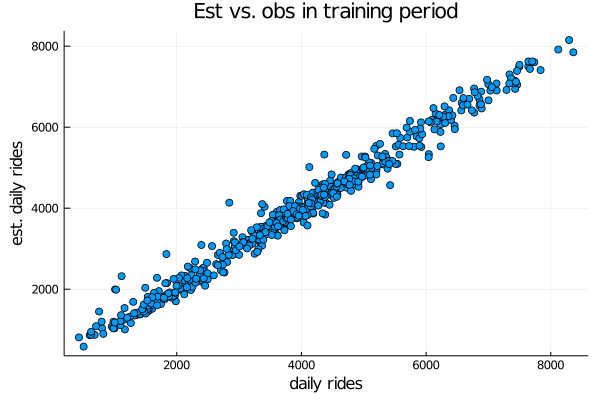

In [28]:
scatter(ytrain,ŷtrain2,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period")

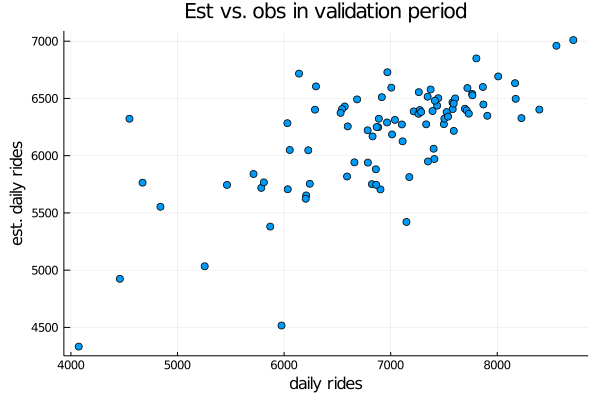

In [29]:
scatter(yval,ŷval2,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period")

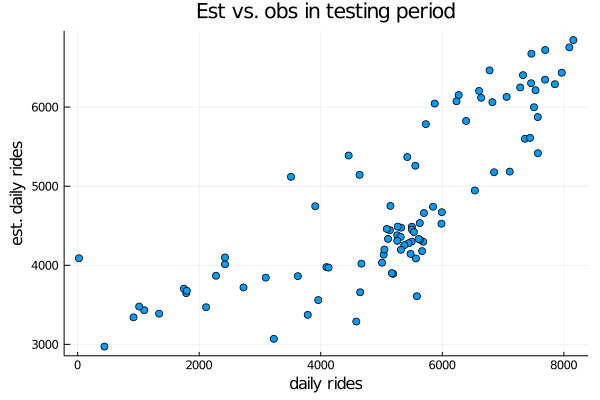

In [30]:
scatter(ytest,ŷtest2,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period")

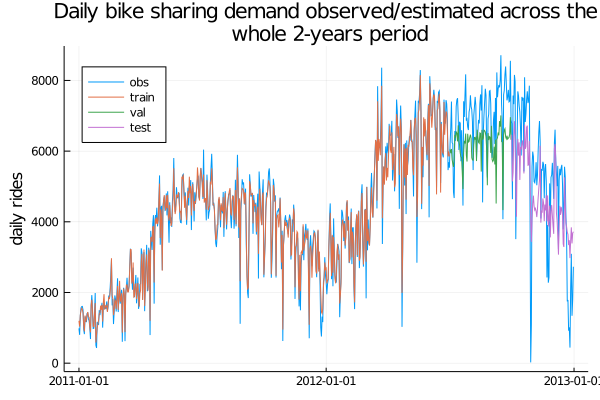

In [31]:
# Full period plot (2 years)
ŷtrainfull = vcat(ŷtrain2,fill(missing,nval+ntest))
ŷvalfull = vcat(fill(missing,ntrain), ŷval2, fill(missing,ntest))
ŷtestfull = vcat(fill(missing,ntrain+nval), ŷtest2)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfull ŷvalfull ŷtestfull], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period")

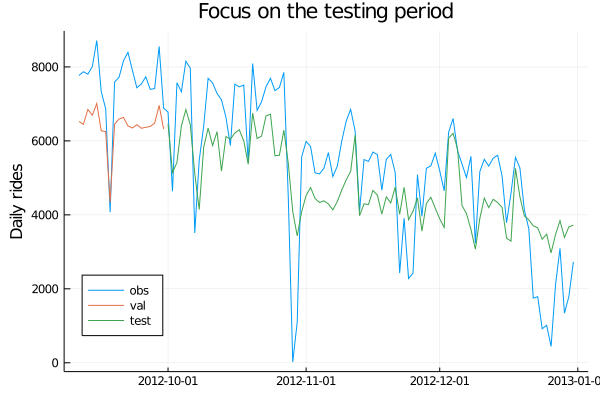

In [32]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfull[stc:endc] ŷtestfull[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period")